In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import math

from torch.utils.data import DataLoader

import torch
import torch.nn as nn

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
src_domain = 'FSeg'
tgt_domain = 'Thebe'

da_method = 'MMD'
w_domain = 0.1
# w_domain = 'adjust'

# data
red = 0 # reduction factor
n_imgs = 16000  # {3200, 6400} max: 49770
bs = 16 # batch size
type_aug = 'type1' # type0, type1, type0_1 (src0 -> tgt1)
nw = 1 # num_workers

# model
net = 'unet2d' # unet2d / dexined
f = 16 # filters on first layer -> unet
n_blocks = 3  # blocks on encode / decode -> unet
bn = False # batch normalization
dropout = False
branch = 'conv_3'

# training
optimizer = 'Adam'
lr = 1e-4
lr_adjust = False
epochs = 20 # 150
loss = 'BCE_MMD'

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [4]:
from dataloaders import ThebeGenerator, FaultSeg2DGenerator

In [5]:
dataset = 'Thebe'
DATAPATH = os.path.join(DATAFOLDER, dataset)

ps = '256to128' # patch size
step = 3 # step size

DATAPATH_TH_SRC = os.path.join(DATAPATH, 'Patches2D', 'src_ps{}_step{}'.format(ps, step) )
DATAPATH_TH_TGT = os.path.join(DATAPATH, 'Patches2D', 'tgt_ps{}_step{}'.format(ps, step) )

train_gen_TH = ThebeGenerator(DATAPATH_TH_TGT, "train", red=red, n_imgs=n_imgs, aug=type_aug)
val_gen_TH = ThebeGenerator(DATAPATH_TH_SRC, "val", red=red, n_imgs=n_imgs)
len(train_gen_TH.list_IDs) # max. 497700

16000

In [6]:
dataset = 'FaultSeg3D'
DATAPATH_FS = os.path.join(DATAFOLDER, dataset)

train_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "train", red=red, n_imgs=n_imgs, aug=type_aug)
val_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "val", red=red, n_imgs=n_imgs)
len(train_gen_FS.list_IDs) # 51200

16000

In [7]:
train_tgt = DataLoader(dataset=train_gen_TH, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_tgt = DataLoader(dataset=val_gen_TH, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

train_src = DataLoader(dataset=train_gen_FS, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_src = DataLoader(dataset=val_gen_FS, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

## Modeling

In [8]:
from models.unet_mmd import UNet2D
from loss import mmd_dsn as mmd_distance

model = UNet2D(f1=f, branches=branch.split(',')).to(device)

In [9]:
opt = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.BCELoss()
criterion_distance = mmd_distance

## Training

In [10]:
from metrics import *

In [11]:
# saved_name = wandb.run.id
# saved_path = os.path.join(PATH, 'res', '{}.pt'.format(saved_name))
# wandb.config.update({"saved_path": saved_name})

saved_path = "delete.pt"

stopPatience = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=stopPatience//2, verbose=True)
saved_path

'delete.pt'

In [12]:
def process(load_src, load_tgt, model, phase='train', opt=None, epoch=0):

    task_loss_ = 0.
    transfer_loss_ = 0.
    total_loss_ = 0.
    
    iou_ = 0.
    iou_tgt_ = 0.
    iou_tgt = 0. # NO BORRAR
    
    len_data = len(load_src)
    epoch += 1
    
    if phase=='train':
        model.train() 
        if lr_adjust:
            for param_group in opt.param_groups:
                param_group['lr'] = lr / math.pow((1 + 10 * (epoch - 1) / epochs), 0.75)
    else:
        model.eval()

    if w_domain == 'adjust':
        weight_domain = 2 / (1 + np.exp(-10 * (epoch) / epochs)) - 1
    else:
        weight_domain = w_domain

    for step, ((x_src, y_src), (x_tgt, y_tgt)) in enumerate(zip(load_src, load_tgt)):
        
        # make images variable
        x_src = x_src.float().to(device=device)
        y_src = y_src.to(device=device).unsqueeze(1)
        x_tgt = x_tgt.float().to(device=device)
        y_tgt = y_tgt.to(device=device).unsqueeze(1)        
        
        # source domain
        src_class_output, src_fts = model(x_src)
        src_loss_class = criterion(src_class_output, y_src)
        
        # target domain
        tgt_class_output, tgt_fts = model(x_tgt)

        transfer_loss = 0.
        for src_ft, tgt_ft in zip(src_fts, tgt_fts):
            transfer_loss += criterion_distance(src_ft, tgt_ft)

        transfer_loss = weight_domain*(transfer_loss/len(src_fts))

        total_loss = src_loss_class + transfer_loss
        
        if phase=='train':
            # calculate the gradients
            opt.zero_grad()
            total_loss.backward()

            # update weigths
            opt.step()
        
        ## compute loss
        task_loss_ += src_loss_class.item()
        transfer_loss_ += transfer_loss.item()
        total_loss_ += total_loss.item()
        
        ## compute metrics
        pred_ = (src_class_output > 0.5).float() 
        iou_ += compute_iou(pred_.squeeze(1), y_src.squeeze(1))
        
        if phase=='val':
            pred_2 = (tgt_class_output > 0.5).float()
            iou_tgt_ += compute_iou(pred_2.squeeze(1), y_tgt.squeeze(1))
 
    task_loss = task_loss_/len_data
    transfer_loss = transfer_loss_/len_data
    total_loss = total_loss_/len_data
    
    iou = iou_/len_data
    if phase=='val':
        iou_tgt = iou_tgt_/len_data
        scheduler.step(task_loss)
        
    return task_loss, transfer_loss, total_loss, iou, iou_tgt

In [13]:
min_valid_loss = np.inf
max_valid_vl = -np.inf
n_patience = 0
t_start = time.time()
t_start_total = time.time()

for ep in range(epochs):
    
    task_loss_tr, transfer_loss_tr, total_loss_tr, iou_src_tr, iou_tgt_tr = \
    process(train_src, train_tgt, model, phase='train', opt=opt, epoch=ep)

    with torch.no_grad():
        task_loss_vl, transfer_loss_vl, total_loss_vl, iou_src_vl, iou_tgt_vl = \
        process(val_src, val_tgt, model, phase='val', epoch=ep)
        
    t_ = time.time()-t_start
    
    for param_group in opt.param_groups:
        lr_step = param_group['lr']  
    
#     wandb.log({
#         "train/epoch/time": t_,
#         "train/epoch/step": ep+1,
#         "lr/step": lr_step,
        
#         "train/epoch/task_loss": task_loss_tr,
#         "train/epoch/transfer_loss": transfer_loss_tr,
#         "train/epoch/total_loss": total_loss_tr,
#         "train/epoch/iou/src": iou_src_tr,
# #         "train/epoch/iou/tgt": iou_tgt_tr,
        
#         "val/epoch/task_loss": task_loss_vl,
#         "val/epoch/transfer_loss": transfer_loss_vl,
#         "val/epoch/total_loss": total_loss_vl,
#         "val/epoch/iou/src": iou_src_vl,
#         "val/epoch/iou/tgt": iou_tgt_vl
#     })
    
    
    print('Epoch {}:   {:.1f}s - task_loss: {:.4f} - transfer_loss: {:.4f} - iou_src: {:.4f}'.format(ep+1, t_, task_loss_tr, transfer_loss_tr, iou_src_tr))
    print('                   val_task_loss: {:.4f} - val_transfer_loss: {:.4f} - val_iou_src: {:.4f} - val_iou_tgt: {:.4f}'.format(task_loss_vl, transfer_loss_vl, iou_src_vl, iou_tgt_vl))
#     print('')
    
#     if (ep+1)%10 == 0:
#         torch.save(model.state_dict(), saved_path)

    loss_vl = total_loss_vl
    
    if min_valid_loss > loss_vl:
        print(f'val_loss improved from {min_valid_loss:.6f} to {loss_vl:.6f} , saving model\n')
        min_valid_loss = loss_vl
        torch.save(model.state_dict(), saved_path)
        n_patience=0
    else:
        print(f'val_loss did not improve from {min_valid_loss:.6f}\n')
        n_patience+=1
        if n_patience==stopPatience:
            print('Epoch {}:   early stopping'.format(ep+1))
            break
            
    t_start = time.time()
    
t_total = time.time() - t_start_total

Epoch 1:   97.5s - task_loss: 0.2795 - transfer_loss: 0.0026 - iou_src: 0.0000
                   val_task_loss: 0.2080 - val_transfer_loss: 0.0002 - val_iou_src: 0.0000 - val_iou_tgt: 0.0000
val_loss improved from inf to 0.208235 , saving model

Epoch 2:   99.4s - task_loss: 0.2288 - transfer_loss: 0.0002 - iou_src: 0.0009
                   val_task_loss: 0.1737 - val_transfer_loss: 0.0001 - val_iou_src: 0.0356 - val_iou_tgt: 0.0084
val_loss improved from 0.208235 to 0.173794 , saving model

Epoch 3:   105.6s - task_loss: 0.2038 - transfer_loss: 0.0001 - iou_src: 0.1124
                   val_task_loss: 0.1647 - val_transfer_loss: 0.0000 - val_iou_src: 0.1579 - val_iou_tgt: 0.0426
val_loss improved from 0.173794 to 0.164790 , saving model

Epoch 4:   106.6s - task_loss: 0.1961 - transfer_loss: 0.0001 - iou_src: 0.1641
                   val_task_loss: 0.1594 - val_transfer_loss: 0.0000 - val_iou_src: 0.1828 - val_iou_tgt: 0.0525
val_loss improved from 0.164790 to 0.159479 , saving mo

In [14]:
t_total/60, ep

(43.270530446370444, 19)

## Validation

In [15]:
model.load_state_dict(torch.load(saved_path))
model.eval()
print()

In [16]:
for idx, (x_tgt, y_tgt) in enumerate(val_tgt):
    print(x_tgt.shape, y_tgt.shape)
    break

torch.Size([16, 1, 128, 128]) torch.Size([16, 128, 128])


In [17]:
y_tgt_prob = model(x_tgt.float().to(device))[0].cpu().detach().numpy()
y_tgt_pred = np.where(y_tgt_prob[:,0] >= 0.5, 1, 0)
y_tgt_prob.shape, y_tgt_pred.shape

((16, 1, 128, 128), (16, 128, 128))

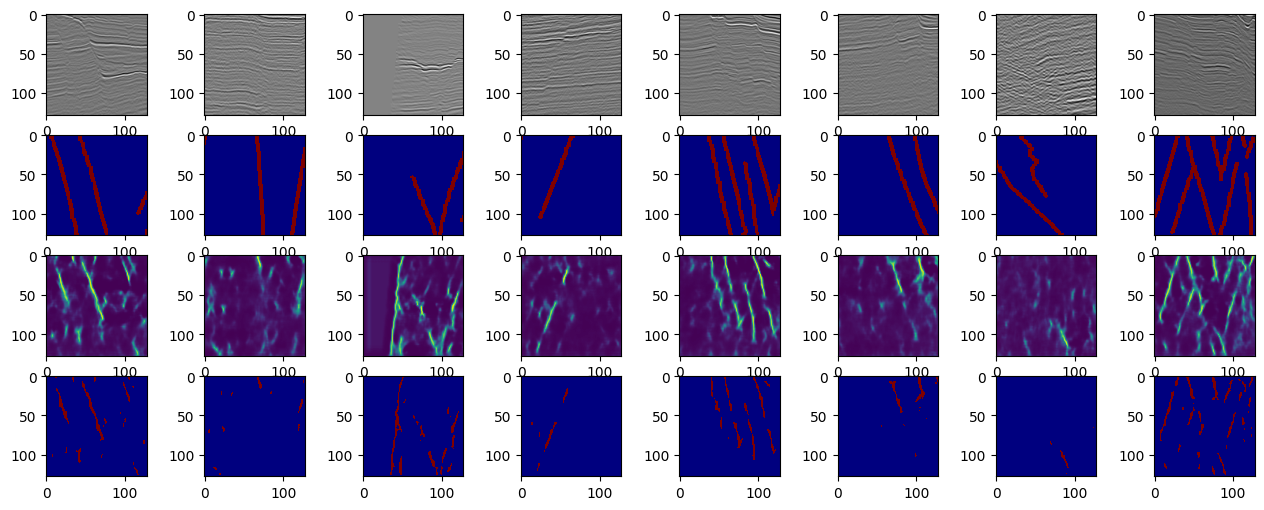

In [18]:
fig, axes = plt.subplots(4, 8, figsize=[16,6])

for i in range(8):
    axes[0, i].imshow(x_tgt[i,0], cmap="gray")
    axes[1, i].imshow(y_tgt[i], cmap="jet", interpolation="nearest")
    axes[2, i].imshow(y_tgt_prob[i,0])
    axes[3, i].imshow(y_tgt_pred[i], cmap="jet", interpolation="nearest")
    
# wandb.log({"valid/imgs_tgt": fig})

### Metrics

In [19]:
import pandas as pd
from tqdm import tqdm

In [20]:
val_tgt = DataLoader(dataset=val_gen_TH, batch_size=128, shuffle=False, drop_last=True,
                     num_workers=4)

y_true_list = []
y_prob_list = []
for x_tgt, y_tgt in tqdm(val_tgt):
    y_tgt = y_tgt.cpu().detach().numpy()
    y_prob = model(x_tgt.float().to(device))[0].cpu().detach().numpy() # probs
    
    y_true_list.append(y_tgt)
    y_prob_list.append(y_prob[:,0])
    
y_true_total = np.vstack(y_true_list)  #.ravel()
y_prob_total = np.vstack(y_prob_list) #.ravel()
y_pred_total = np.where(y_prob_total >= 0.5, 1, 0)

y_true_total.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.04it/s]


(4352, 128, 128)

In [21]:
th_range = np.arange(0, 1, 0.02)
metrics_list = []

y_true = torch.tensor(y_true_total, dtype=torch.float32).to(device)
y_prob = torch.tensor(y_prob_total, dtype=torch.float32).to(device)

for th in th_range:
    pr, re, f1 = binary_classification_metrics(y_prob, y_true, th)
    metrics_list.append([pr, re, f1])

In [22]:
df = pd.DataFrame(np.array(metrics_list)).reset_index(drop=True)
df.columns = ['precision', 'recall', 'f1_score']
df.index = th_range

In [23]:
f1_ = df.loc[0.5]['f1_score']
# wandb.log({"valid/f1_tgt": f1_})

In [24]:
iou = compute_iou((y_prob > 0.5).float(), y_true.contiguous())
# wandb.log({"valid/iou_tgt": iou})

In [25]:
print("Original:  IoU: {:.4f}   F1-score: {:.4f}".format(iou, f1_))

Original:  IoU: 0.1387   F1-score: 0.2436


### New Metrics

In [26]:
getNewMetrics(y_true_total, y_pred_total, sigma=1) #, wandb=wandb)

1266it [00:02, 544.73it/s]C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  iou = 1/(1/recall+1/precision-1)
C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:158: RuntimeWarning: divide by zero encountered in scalar divide
  f1 = 2/(1/recall+1/precision)
1877it [00:03, 548.92it/s]C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:94: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(d)/np.sum(n)
4352it [00:07, 548.59it/s]

With Sigma=1:  IoU: 0.2003   F1-score: 0.3139


In [27]:
getNewMetrics(y_true_total, y_pred_total, sigma=4) #, wandb=wandb)

4352it [00:07, 613.00it/s]

With Sigma=4:  IoU: 0.3841   F1-score: 0.5219


In [28]:
getNewMetrics(y_true_total, y_pred_total, sigma=7) #, wandb=wandb)

4352it [00:07, 613.05it/s]

With Sigma=7:  IoU: 0.4743   F1-score: 0.6105


In [29]:
# wandb.finish()